In [27]:
import pickle
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import datetime
import seaborn as sn
import pandas as pd
import numpy as np

In [28]:
tf.random.set_seed(1234)

In [29]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Data preprocessing


In [30]:
# Wczytanie zbioru danych
dataset_path = '../mlp-98c-kornelro/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
def get_preprocessed_data(subset_type, batch=False):

    images = dataset[subset_type]['X']
    labels = dataset[subset_type]['y']

    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )

    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
        
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])

    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    if batch:
        ds = tf.data.Dataset.from_tensor_slices((images, labels))
        ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=100)
    else:
        ds = {'X': images, 'y': labels}

    return ds

train_ds = get_preprocessed_data('train', True)
val_ds = get_preprocessed_data('validation')
test_ds = get_preprocessed_data('test')

### Base classes

In [31]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Implementations

In [32]:
class FullyConnected(AbstractLayer):

    def __init__(self, input_shape, units):
        super(FullyConnected, self).__init__()
        #initializer = 

        self.w = self.add_weight(
            shape=([input_shape[-1], units]),
            initializer='random_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            shape=([units]),
            initializer='random_uniform',
            trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [33]:
class Model(AbstractModel):

    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = FullyConnected([1, 12288], 256)
        self.act1 = tf.keras.activations.relu
        self.fc2 = FullyConnected([1, 256], 14)
        self.act2 = tf.keras.activations.softmax

    def call(self, inputs, training=False):
        inputs = tf.reshape(inputs, [-1, 64*64*3])
        X = self.fc1(inputs)
        X = self.act1(X)
        X = self.fc2(X)
        X = self.act2(X)

        return X 

    def fit(self, train_ds, val_ds, epochs, loss_fn, eval_fn, optimizer):
        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        val_log_dir = 'logs/gradient_tape/' + current_time + '/validation'
        val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        train_loss_m = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        train_f1_m = tf.keras.metrics.Mean('train_f1', dtype=tf.float32)

        for epoch in range(epochs):
            for x_batch, y_batch in tqdm(train_ds):
                with tf.GradientTape() as tape:
                    probs = self.call(x_batch)
                    loss = loss_fn(y_batch, probs)
                    train_loss_m(loss)
                    f1 = eval_fn(y_batch, probs)
                    train_f1_m(f1)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
            train_loss = train_loss_m.result()
            train_f1 = train_f1_m.result()
            with train_summary_writer.as_default():
                tf.summary.scalar('train_loss', train_loss, step=epoch+1)
                tf.summary.scalar('train_f1', train_f1, step=epoch+1)
            train_loss_m.reset_states()
            train_f1_m.reset_states()

            val_probs = self.call(val_ds['X'])
            val_loss = loss_fn(val_ds['y'], val_probs)
            val_f1 = eval_fn(val_ds['y'], val_probs)
            with val_summary_writer.as_default():
                tf.summary.scalar('val_loss', val_loss, step=epoch+1)
                tf.summary.scalar('val_f1', val_f1, step=epoch+1)
                
            template = 'Epoch {}, Train Loss: {}, Train F1: {}, Val Loss: {}, Val F1: {}'
            print (template.format(epoch+1, train_loss, train_f1, val_loss, val_f1))

### Learning

In [34]:
def f1_eval(y_true, y_pred_probs):
    y_true = tf.reshape(y_true, y_true.shape[0])
    y_pred = tf.math.argmax(y_pred_probs, 1)
    y_pred = tf.reshape(y_pred, y_pred.shape[0])
    
    return f1_score(y_true, y_pred, average='macro')

In [35]:
model = Model()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.fit(train_ds, val_ds, 25, loss_fn, f1_eval, optimizer)

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.68526554107666, Train F1: 0.034252844750881195, Val Loss: 2.528918504714966, Val F1: 0.04197875409444513


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.4336018562316895, Train F1: 0.09200438112020493, Val Loss: 2.4377048015594482, Val F1: 0.11385528546803982


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.3860812187194824, Train F1: 0.11545100063085556, Val Loss: 2.387159824371338, Val F1: 0.12079129364331632


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.3538694381713867, Train F1: 0.12542691826820374, Val Loss: 2.3858914375305176, Val F1: 0.12311429511267531


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.3180277347564697, Train F1: 0.14760331809520721, Val Loss: 2.351273775100708, Val F1: 0.13696518323731216


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.2889270782470703, Train F1: 0.16240184009075165, Val Loss: 2.337005376815796, Val F1: 0.1731375117412093


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.27510142326355, Train F1: 0.1587744802236557, Val Loss: 2.3475897312164307, Val F1: 0.15060136525631726


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.2546145915985107, Train F1: 0.17420685291290283, Val Loss: 2.3608603477478027, Val F1: 0.16361030503406085


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.212653160095215, Train F1: 0.19010880589485168, Val Loss: 2.3216817378997803, Val F1: 0.17169390232480095


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.213097333908081, Train F1: 0.19199709594249725, Val Loss: 2.3378076553344727, Val F1: 0.1879154118550672


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.167698860168457, Train F1: 0.21098113059997559, Val Loss: 2.315335512161255, Val F1: 0.16447870807470572


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.1487443447113037, Train F1: 0.2243501842021942, Val Loss: 2.3444888591766357, Val F1: 0.17585248214920599


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13, Train Loss: 2.180649518966675, Train F1: 0.20936059951782227, Val Loss: 2.348592519760132, Val F1: 0.14618672264798957


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14, Train Loss: 2.1502723693847656, Train F1: 0.21393349766731262, Val Loss: 2.3126564025878906, Val F1: 0.1782525777864245


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.1184170246124268, Train F1: 0.22784042358398438, Val Loss: 2.349669933319092, Val F1: 0.16503874616008135


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16, Train Loss: 2.0898427963256836, Train F1: 0.23191241919994354, Val Loss: 2.349376678466797, Val F1: 0.16576197588199681


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17, Train Loss: 2.0735220909118652, Train F1: 0.2459447681903839, Val Loss: 2.3291919231414795, Val F1: 0.17181469130183968


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18, Train Loss: 2.026024580001831, Train F1: 0.2648211717605591, Val Loss: 2.313446521759033, Val F1: 0.19178798548488313


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19, Train Loss: 1.9952529668807983, Train F1: 0.2744266986846924, Val Loss: 2.345629930496216, Val F1: 0.17822422018614809


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20, Train Loss: 1.9658019542694092, Train F1: 0.2935633063316345, Val Loss: 2.323692798614502, Val F1: 0.19534880522892423


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21, Train Loss: 1.9313606023788452, Train F1: 0.30124786496162415, Val Loss: 2.355268955230713, Val F1: 0.18599116734669674


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22, Train Loss: 1.8889707326889038, Train F1: 0.32086774706840515, Val Loss: 2.3491692543029785, Val F1: 0.20050497920015267


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23, Train Loss: 1.8981177806854248, Train F1: 0.31785446405410767, Val Loss: 2.5023958683013916, Val F1: 0.1638843666520653


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24, Train Loss: 1.8710490465164185, Train F1: 0.3278055787086487, Val Loss: 2.369310140609741, Val F1: 0.1970954619462036


100%|██████████| 89/89 [00:02<00:00, 30.76it/s]


Epoch 25, Train Loss: 1.8337886333465576, Train F1: 0.3484881818294525, Val Loss: 2.412658214569092, Val F1: 0.1989709018635464


### Results

In [36]:
!lsof -i tcp:6006 | awk 'NR!=1 {print $2}' | xargs kill 
%tensorboard --host 0.0.0.0 --port 6006 --logdir logs/gradient_tape

In [37]:
y_true = tf.reshape(test_ds['y'], test_ds['y'].shape[0])
y_pred_probs = model(test_ds['X'])

In [38]:
print('Test F1: '+str(f1_eval(y_true, y_pred_probs)))

Test F1: 0.20258181687144197


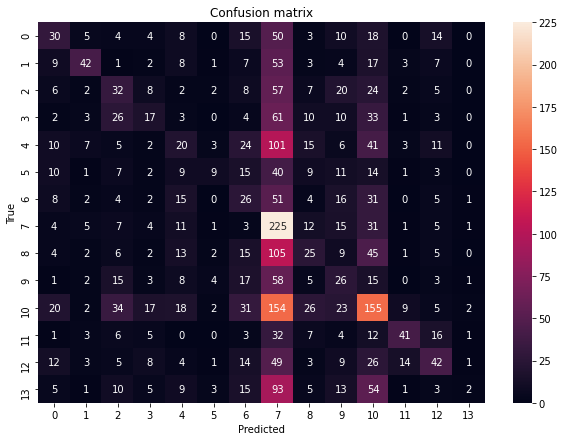

In [39]:
y_pred = tf.math.argmax(y_pred_probs, 1)
y_pred = tf.reshape(y_pred, y_pred.shape[0])

labels = tf.unique(y_true)[0].numpy()
labels.sort()

matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

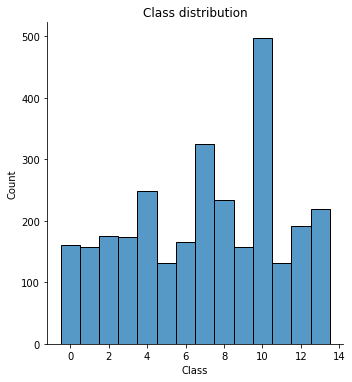

In [40]:
sn.displot(y_true.numpy(), discrete=True)
plt.xlabel('Class')
plt.title('Class distribution')
plt.show()

In [41]:
def get_misclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] != y_pred.numpy()[i] and y_true.numpy()[i] == c]

def get_properclasified(c):
    return [i for i in range(len(y_true.numpy()))
                 if y_true.numpy()[i] == y_pred.numpy()[i] and y_true.numpy()[i] == c]

def plot_misclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_misclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[0]].numpy())+' | PREDICTED: '+str(c))
    axs[1].imshow(test_ds['X'][get_misclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[1]].numpy())+' | PREDICTED: '+str(c))
    axs[2].imshow(test_ds['X'][get_misclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+str(y_pred[get_misclasified(c)[2]].numpy())+' | PREDICTED: '+str(c))
    plt.show()
    
def plot_properclasified(c):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(test_ds['X'][get_properclasified(c)[0]])
    axs[0].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[0]].numpy())+' | PREDICTED: '+str(c))
    axs[1].imshow(test_ds['X'][get_properclasified(c)[1]])
    axs[1].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[1]].numpy())+' | PREDICTED: '+str(c))
    axs[2].imshow(test_ds['X'][get_properclasified(c)[2]])
    axs[2].title.set_text('TRUE: '+str(y_pred[get_properclasified(c)[2]].numpy())+' | PREDICTED: '+str(c))
    plt.show()

#### Misclasified class = 13

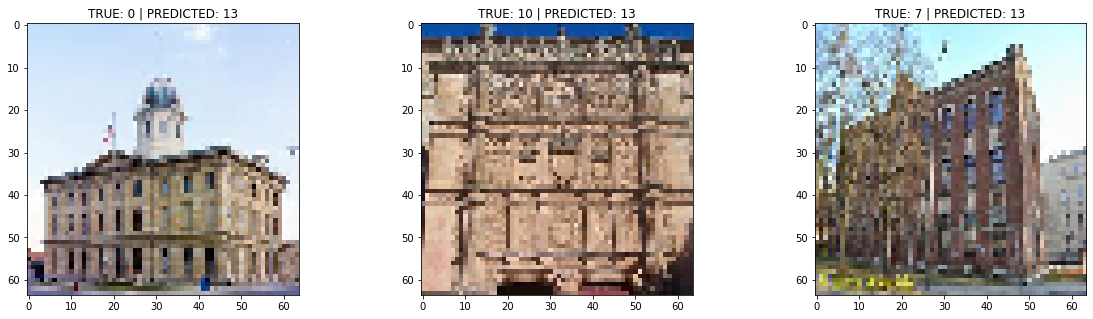

In [42]:
plot_misclasified(13)

#### Misclasified class = 5

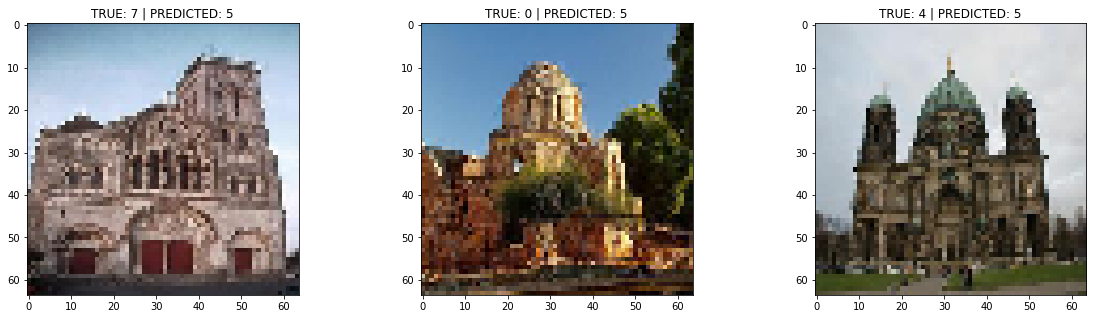

In [43]:
plot_misclasified(5)

#### Properclasified class = 10

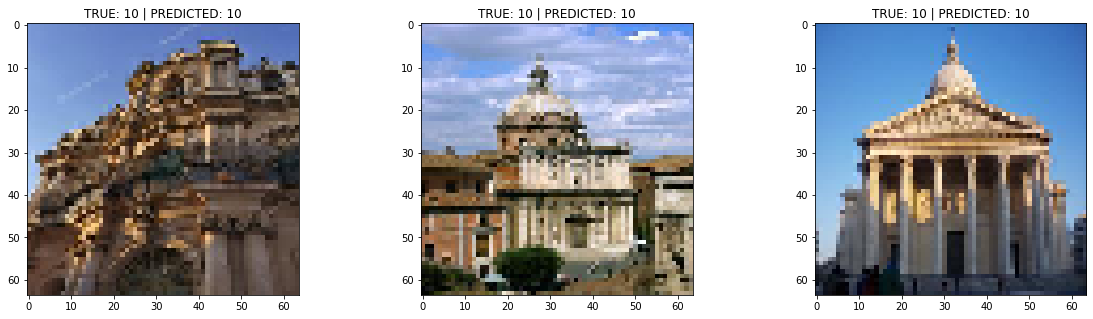

In [44]:
plot_properclasified(10)